In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture

In [2]:
def grid(hdr_x, hdr_y, cen_x, cen_y):
    Xg, Yg = np.meshgrid(np.arange(0, hdr_x, 1),np.arange(0, hdr_y, 1))
    r = np.sqrt((Xg-cen_x)**2+(Yg-cen_y)**2)
    return r

def flux_measure(measured, bg, r):
    N = len(measured[r<=20])
    net_flux = np.sum(measured[r<=20])-N*bg
    return net_flux

def mag(standard, choosed, standard_mag):
    mag = -2.5*np.log10(choosed/standard)+standard_mag
    return mag

def absolute_Vmag(mag):
    distance = 0.487*1000*u.pc
    M = mag-5*np.log10(distance/(10*u.pc))
    return M

# first
standard star (264.997309, -32.443306) magV: 10.011 magB: 9.889

In [3]:
with fits.open("V_3s.fits") as v3s_hdul:
    v3s_data = np.float64(v3s_hdul[0].data)
    v3s_hdr = v3s_hdul[0].header
    v3s_wcs = WCS(v3s_hdul[0].header)
v3s_mean, v3s_median, v3s_std = sigma_clipped_stats(v3s_data, sigma=3)  
# print((v3s_mean, v3s_median, v3s_std)) 
daofind = DAOStarFinder(fwhm=4.0, threshold=3*v3s_std)  
v3s_sources = daofind(v3s_data - v3s_mean)  
for col in v3s_sources.colnames:  
    if col not in ('id', 'npix'):
        v3s_sources[col].info.format = '%.2f'  # for consistent table output
v3s_sources.pprint(max_width=76)

  id  xcentroid ycentroid sharpness roundness1 ... sky   peak  flux  mag 
----- --------- --------- --------- ---------- ... ---- ----- ----- -----
    1   1293.90      1.03      0.40       0.64 ... 0.00  1.21  1.25 -0.24
    2   1641.08      1.43      0.55       0.79 ... 0.00  1.21  1.04 -0.04
    3   3455.22      1.30      0.42       0.37 ... 0.00  1.21  1.05 -0.05
    4    656.02      2.96      0.55      -0.32 ... 0.00  1.21  1.09 -0.09
    5    828.60      1.97      0.58       0.60 ... 0.00  2.21  1.16 -0.16
    6   2280.95      3.25      0.50      -0.10 ... 0.00  1.21  1.20 -0.19
    7   2606.64      2.27      0.92      -0.74 ... 0.00  3.21  1.24 -0.23
    8   2643.51      2.69      0.52       0.07 ... 0.00  3.21  1.48 -0.42
    9   2723.91      2.27      0.79      -0.70 ... 0.00  2.21  1.05 -0.05
   10   2910.25      2.45      0.41       0.31 ... 0.00  1.21  1.20 -0.20
  ...       ...       ...       ...        ... ...  ...   ...   ...   ...
40608   4608.01   4365.26      0.87   

In [4]:
peak_v3s = v3s_sources["peak"]
choosed_star_v3s = v3s_sources[(peak_v3s<50000) & (peak_v3s>5000)]

In [5]:
standstard1_coor = SkyCoord(264.997309, -32.443306, unit='deg')
standstard1_x, standstard1_y = v3s_wcs.world_to_pixel(standstard1_coor)
r_v3s = grid(v3s_hdr["NAXIS1"], v3s_hdr["NAXIS2"], standstard1_x, standstard1_y)
flux_standstard1_v3s = flux_measure(v3s_data, v3s_mean, r_v3s) 

choosed_star_flux_v3s = np.array([])
for num in range(len(choosed_star_v3s)):
    r_target = grid(v3s_hdr["NAXIS1"], v3s_hdr["NAXIS2"], choosed_star_v3s["xcentroid"][num], choosed_star_v3s["ycentroid"][num])
    flux = flux_measure(v3s_data, v3s_mean, r_target)
    choosed_star_flux_v3s = np.append(choosed_star_flux_v3s, flux)
    
choosed_star_Vmag_v3s = np.array([])
standard_Vmag = 10.011
for num in range(len(choosed_star_flux_v3s)):
    Vmag_v3s = mag(flux_standstard1_v3s, choosed_star_flux_v3s[num], standard_Vmag)
    choosed_star_Vmag_v3s = np.append(choosed_star_Vmag_v3s, Vmag_v3s)
choosed_star_Vmag_v3s

choosed_star_Mv_v3s = np.array([])
for num in range(len(choosed_star_Vmag_v3s)):
    Mv_v3s = absolute_Vmag(choosed_star_Vmag_v3s[num])
    choosed_star_Mv_v3s = np.append(choosed_star_Mv_v3s, Mv_v3s)
choosed_star_Mv_v3s = np.array(choosed_star_Mv_v3s)

In [6]:
with fits.open("B_4s.fits") as B4s_hdul:
    B4s_data = np.float64(B4s_hdul[0].data)
    B4s_hdr = B4s_hdul[0].header
    B4s_wcs = WCS(B4s_hdul[0].header)
B4s_mean, B4s_median, B4s_std = sigma_clipped_stats(B4s_data, sigma=3.0)

In [7]:
choosed_stars1_coord = v3s_wcs.pixel_to_world(choosed_star_v3s["xcentroid"], choosed_star_v3s["ycentroid"])
choosed_stars1_B4s_x, choosed_stars1_B4s_y = B4s_wcs.world_to_pixel(choosed_stars1_coord)

In [8]:
standstard1_coor = SkyCoord(264.997309, -32.443306, unit='deg')
standstard1_x, standstard1_y = B4s_wcs.world_to_pixel(standstard1_coor)
r_B4s = grid(B4s_hdr["NAXIS1"], B4s_hdr["NAXIS2"], standstard1_x, standstard1_y)
flux_standstard1_B4s = flux_measure(B4s_data, B4s_mean, r_B4s) # calculate flux

choosed_star_flux_B4s = np.array([])
for num in range(len(choosed_star_v3s)):
    r_target = grid(B4s_hdr["NAXIS1"], B4s_hdr["NAXIS2"], choosed_stars1_B4s_x[num], choosed_stars1_B4s_y[num])
    flux = flux_measure(B4s_data, B4s_mean, r_target)
    choosed_star_flux_B4s = np.append(choosed_star_flux_B4s, flux)

choosed_star_Bmag_B4s = np.array([])
standard_Bmag = 9.889
for num in range(len(choosed_star_flux_B4s)):
    Bmag_B4s = mag(flux_standstard1_B4s, choosed_star_flux_B4s[num], standard_Bmag)
    choosed_star_Bmag_B4s = np.append(choosed_star_Bmag_B4s, Bmag_B4s)

B_minus_V_first = choosed_star_Bmag_B4s-choosed_star_Vmag_v3s

# second
standard star 2 (265.039964, -32.445354) magV: 10.507 magB: 10.51


In [9]:
with fits.open("V_30s.fits") as v30s_hdul:
    v30s_data = np.float64(v30s_hdul[0].data)
    v30s_hdr = v30s_hdul[0].header
    v30s_wcs = WCS(v30s_hdul[0].header)
v30s_mean, v30s_median, v30s_std = sigma_clipped_stats(v30s_data, sigma=3)
daofind = DAOStarFinder(fwhm=4.0, threshold=3*v30s_std)  
v30s_sources = daofind(v30s_data - v30s_mean)  
for col in v30s_sources.colnames:  
    if col not in ('id', 'npix'):
        v30s_sources[col].info.format = '%.2f'  # for consistent table output
v30s_sources.pprint(max_width=76)

 id  xcentroid ycentroid sharpness roundness1 ... sky   peak   flux  mag 
---- --------- --------- --------- ---------- ... ---- ------ ----- -----
   1   1607.58      1.28      0.48       0.18 ... 0.00  22.54  5.25 -1.80
   2   4887.75      1.11      0.54      -0.05 ... 0.00  28.54  6.50 -2.03
   3   2446.80      0.28      0.50       0.38 ... 0.00  -8.46  1.31 -0.29
   4   1293.25      4.95      0.55      -0.40 ... 0.00 -10.46  1.13 -0.13
   5   1410.10      5.34      0.62      -0.24 ... 0.00 -13.46  1.07 -0.07
   6   2449.03      5.43      0.30      -0.43 ... 0.00 -11.46  1.31 -0.29
   7   2708.96      5.57      0.39       0.25 ... 0.00 -13.46  1.03 -0.04
   8   3404.95      4.68      0.62      -0.65 ... 0.00   0.54  1.49 -0.43
   9   3844.79      6.03      0.39       0.18 ... 0.00 -10.46  1.24 -0.23
  10   4526.75      5.69      0.42       0.24 ... 0.00 548.54 81.83 -4.78
 ...       ...       ...       ...        ... ...  ...    ...   ...   ...
9919   5287.21   4370.79      0.39    

In [10]:
peak_v30s = v30s_sources["peak"]
choosed_star_v30s = v30s_sources[(peak_v30s<50000) & (peak_v30s>5000)]

In [11]:
standstard2_coor = SkyCoord(265.039964, -32.445354, unit='deg')
standstard2_x, standstard2_y = v30s_wcs.world_to_pixel(standstard2_coor)
r_v30s = grid(v30s_hdr["NAXIS1"], v30s_hdr["NAXIS2"], standstard2_x, standstard2_y)
flux_standstard1_v30s = flux_measure(v30s_data, v30s_mean, r_v30s) 

choosed_star_flux_v30s = np.array([])
for num in range(len(choosed_star_v30s)):
    r_target = grid(v30s_hdr["NAXIS1"], v30s_hdr["NAXIS2"], choosed_star_v30s["xcentroid"][num], choosed_star_v30s["ycentroid"][num])
    flux = flux_measure(v30s_data, v30s_mean, r_target)
    choosed_star_flux_v30s = np.append(choosed_star_flux_v30s, flux)
    
choosed_star_Vmag_v30s = np.array([])
standard2_Vmag = 10.507
for num in range(len(choosed_star_flux_v30s)):
    Vmag_v30s = mag(flux_standstard1_v30s, choosed_star_flux_v30s[num], standard2_Vmag)
    choosed_star_Vmag_v30s = np.append(choosed_star_Vmag_v30s, Vmag_v30s)
choosed_star_Vmag_v30s

choosed_star_Mv_v30s = np.array([])
for num in range(len(choosed_star_Vmag_v30s)):
    Mv_v30s = absolute_Vmag(choosed_star_Vmag_v30s[num])
    choosed_star_Mv_v30s = np.append(choosed_star_Mv_v30s, Mv_v30s)
choosed_star_Mv_v30s = np.array(choosed_star_Mv_v30s)

In [12]:
with fits.open("B_40s.fits") as B40s_hdul:
    B40s_data = np.float64(B40s_hdul[0].data)
    B40s_hdr = B40s_hdul[0].header
    B40s_wcs = WCS(B40s_hdul[0].header)
B40s_mean, B40s_median, B40s_std = sigma_clipped_stats(B40s_data, sigma=3.0)

In [13]:
choosed_stars2_coord = v30s_wcs.pixel_to_world(choosed_star_v30s["xcentroid"], choosed_star_v30s["ycentroid"])
choosed_stars2_B40s_x, choosed_stars2_B40s_y = B40s_wcs.world_to_pixel(choosed_stars2_coord)

In [14]:
standstard2_x, standstard2_y = B40s_wcs.world_to_pixel(standstard2_coor)
r_B40s = grid(B40s_hdr["NAXIS1"], B40s_hdr["NAXIS2"], standstard2_x, standstard2_y)
flux_standstard1_B40s = flux_measure(B40s_data, B40s_mean, r_B40s) # calculate flux

choosed_star_flux_B40s = np.array([])
for num in range(len(choosed_star_v30s)):
    r_target = grid(B40s_hdr["NAXIS1"], B40s_hdr["NAXIS2"], choosed_stars2_B40s_x[num], choosed_stars2_B40s_y[num])
    flux = flux_measure(B40s_data, B40s_mean, r_target)
    choosed_star_flux_B40s = np.append(choosed_star_flux_B40s, flux)

choosed_star_Bmag_B40s = np.array([])
standard_Bmag = 10.51
for num in range(len(choosed_star_flux_B40s)):
    Bmag_B40s = mag(flux_standstard1_B40s, choosed_star_flux_B40s[num], standard_Bmag)
    choosed_star_Bmag_B40s = np.append(choosed_star_Bmag_B40s, Bmag_B40s)

B_minus_V_second = choosed_star_Bmag_B40s-choosed_star_Vmag_v30s

# third
standard star3 (264.897787, -32.20748) magV: 14.315 magB: 15.074

In [15]:
with fits.open("V_5min.fits") as v5m_hdul:
    v5m_data = np.float64(v5m_hdul[0].data)
    v5m_hdr = v5m_hdul[0].header
    v5m_wcs = WCS(v5m_hdul[0].header)
v5m_mean, v5m_median, v5m_std = sigma_clipped_stats(v5m_data, sigma=3)
daofind = DAOStarFinder(fwhm=4.0, threshold=3*v5m_std)  
v5m_sources = daofind(v5m_data - v5m_mean)  
for col in v5m_sources.colnames:  
    if col not in ('id', 'npix'):
        v5m_sources[col].info.format = '%.2f'  # for consistent table output
v5m_sources.pprint(max_width=76)

  id  xcentroid ycentroid sharpness ... sky    peak    flux   mag 
----- --------- --------- --------- ... ---- -------- ------ -----
    1   2277.15      1.02      0.52 ... 0.00  3143.39 111.25 -5.12
    2   2796.34      1.45      0.67 ... 0.00   285.39   9.61 -2.46
    3   4501.75      1.31      0.66 ... 0.00   195.39   6.58 -2.05
    4   4749.29      0.83      0.45 ... 0.00  5144.39 195.98 -5.73
    5   5585.70      1.33      0.48 ... 0.00 16935.39 573.71 -6.90
    6      2.61      2.63      0.26 ... 0.00  -107.61   4.87 -1.72
    7      9.97      2.60      0.28 ... 0.00   -32.61   4.39 -1.61
    8   1892.15      2.25      0.34 ... 0.00   209.39  10.53 -2.56
    9   2495.72      1.69      0.34 ... 0.00   275.39  12.07 -2.70
   10   2587.63      2.98      0.33 ... 0.00   119.39   6.15 -1.97
  ...       ...       ...       ... ...  ...      ...    ...   ...
19312   3453.13   4366.70      0.47 ... 0.00   -62.61   2.22 -0.87
19313   3617.22   4369.39      0.78 ... 0.00  1877.39   8.15 -

In [16]:
peak_v5m = v5m_sources["peak"]
choosed_star_v5m = v5m_sources[(peak_v5m<50000) & (peak_v5m>5000)]
choosed_star_v5m = choosed_star_v5m[4:] # because the first four was cutted (too edge)

In [17]:
standstard3_coor = SkyCoord(264.897787, -32.20748, unit='deg')
standstard3_x, standstard3_y = v5m_wcs.world_to_pixel(standstard3_coor)
r_v5m = grid(v5m_hdr["NAXIS1"], v5m_hdr["NAXIS2"], standstard3_x, standstard3_y)
flux_standstard1_v5m = flux_measure(v5m_data, v5m_mean, r_v5m) 

choosed_star_flux_v5m = np.array([])
for num in range(len(choosed_star_v5m)):
    # if num==360 :continue # nan in Bmag
    r_target = grid(v5m_hdr["NAXIS1"], v5m_hdr["NAXIS2"], choosed_star_v5m["xcentroid"][num], choosed_star_v5m["ycentroid"][num])
    flux = flux_measure(v5m_data, v5m_mean, r_target)
    choosed_star_flux_v5m = np.append(choosed_star_flux_v5m, flux)


choosed_star_Vmag_v5m = np.array([])
standard2_Vmag = 14.315
for num in range(len(choosed_star_flux_v5m)):
    Vmag_v5m = mag(flux_standstard1_v5m, choosed_star_flux_v5m[num], standard2_Vmag)
    choosed_star_Vmag_v5m = np.append(choosed_star_Vmag_v5m, Vmag_v5m)

choosed_star_Mv_v5m = np.array([])
for num in range(len(choosed_star_Vmag_v5m)):
    Mv_v5m = absolute_Vmag(choosed_star_Vmag_v5m[num])
    choosed_star_Mv_v5m = np.append(choosed_star_Mv_v5m, Mv_v5m)
choosed_star_Mv_v5m = np.array(choosed_star_Mv_v5m)

In [18]:
with fits.open("B_8min.fits") as B8m_hdul:
    B8m_data = np.float64(B8m_hdul[0].data)
    B8m_hdr = B8m_hdul[0].header
    B8m_wcs = WCS(B8m_hdul[0].header)
B8m_mean, B8m_median, B8m_std = sigma_clipped_stats(B8m_data, sigma=3.0)

In [19]:
choosed_stars3_coord = v5m_wcs.pixel_to_world(choosed_star_v5m["xcentroid"], choosed_star_v5m["ycentroid"])
choosed_stars3_B8m_x, choosed_stars3_B8m_y = B8m_wcs.world_to_pixel(choosed_stars3_coord)

In [20]:
standstard3_x, standstard3_y = B8m_wcs.world_to_pixel(standstard3_coor)
r_B8m = grid(B8m_hdr["NAXIS1"], B8m_hdr["NAXIS2"], standstard3_x, standstard3_y)
flux_standstard1_B8m = flux_measure(B8m_data, B8m_mean, r_B8m) # calculate flux

choosed_star_flux_B8m = np.array([])
for num in range(len(choosed_star_v5m)):
    # if num==360 :continue # nan in Bmag
    r_target = grid(B8m_hdr["NAXIS1"], B8m_hdr["NAXIS2"], choosed_stars3_B8m_x[num], choosed_stars3_B8m_y[num])
    flux = flux_measure(B8m_data, B8m_mean, r_target)
    choosed_star_flux_B8m = np.append(choosed_star_flux_B8m, flux)

choosed_star_Bmag_B8m = np.array([])
standard_Bmag = 15.074
for num in range(len(choosed_star_flux_B8m)):
    Bmag_B8m = mag(flux_standstard1_B8m, choosed_star_flux_B8m[num], standard_Bmag)
    choosed_star_Bmag_B8m = np.append(choosed_star_Bmag_B8m, Bmag_B8m)
    
B_minus_V_third = choosed_star_Bmag_B8m-choosed_star_Vmag_v5m

C:\Users\sl\AppData\Local\Temp\ipykernel_15332\929777201.py:12: RuntimeWarning: invalid value encountered in log10
  mag = -2.5*np.log10(choosed/standard)+standard_mag


In [21]:
Mv = np.array
Mv = np.append(choosed_star_Mv_v3s, choosed_star_Mv_v30s)
Mv = np.append(Mv, choosed_star_Mv_v5m)

B_minus_V = np.array([])
B_minus_V = np.append(B_minus_V_first, B_minus_V_second)
B_minus_V = np.append(B_minus_V, B_minus_V_third)

In [30]:
print(len(Mv), len(B_minus_V))
np.savetxt("Mv.txt", np.transpose(Mv), delimiter=', ')
np.savetxt("B_minus_V.txt", np.transpose(B_minus_V), delimiter=', ')

861 861


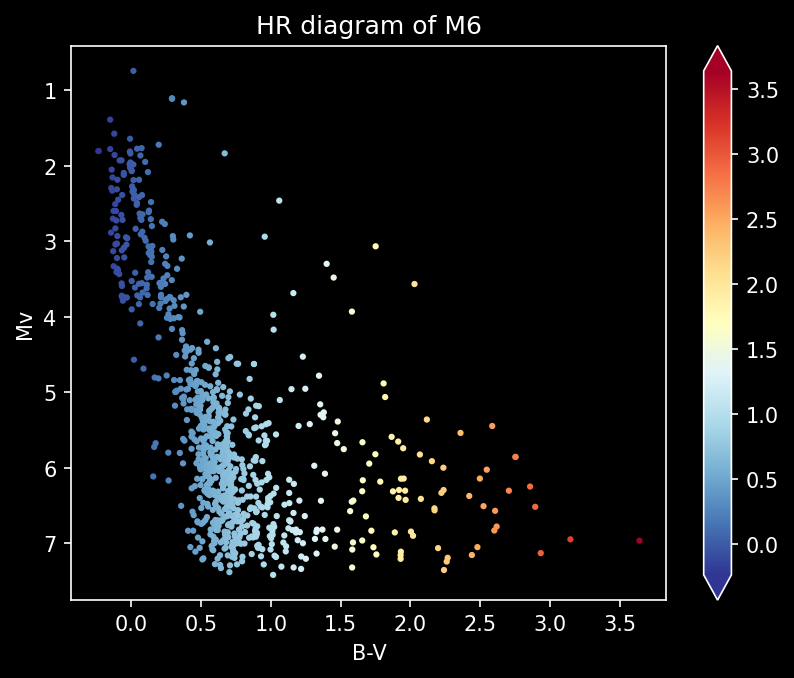

In [27]:
plt.figure(dpi=150)
cmap = plt.colormaps.get_cmap('RdYlBu')  
reversed_cmap = cmap.reversed() 
plt.scatter(B_minus_V, Mv,  s=4, c=B_minus_V, cmap=reversed_cmap)
plt.xlabel('B-V')
plt.ylabel('Mv')
plt.title('HR diagram of M6')
plt.gca().invert_yaxis()
plt.colorbar(extend='both')
plt.style.use("dark_background")
plt.savefig("M6_HRdiagram.png")
plt.show()

# test and find standard stars (can ignore this part)

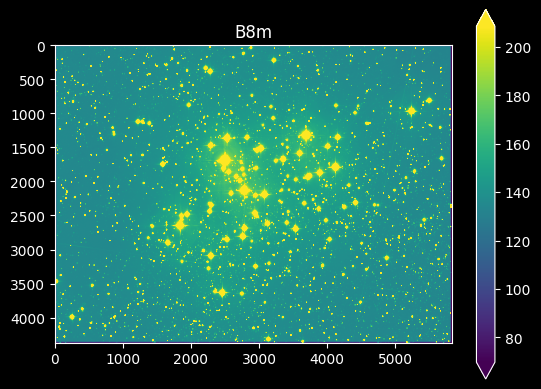

In [24]:
# standstard_test_coor = SkyCoord(264.897787, -32.20748, unit='deg')
# standstard_test_x, standstard_test_y = v5m_wcs.world_to_pixel(standstard_test_coor)
# positions = np.transpose((choosed_star_v5m['xcentroid'][-14], choosed_star_v5m['ycentroid'][-14])) #choosed_star_v30s['xcentroid'], choosed_star_v30s['ycentroid']
# apertures = CircularAperture(positions, r=20.0)
vmin, vmax = ZScaleInterval().get_limits(B8m_data)
plt.imshow(B8m_data, vmin=vmin, vmax=vmax)
plt.title('B8m')
plt.colorbar(extend='both')
# apertures.plot(color='red', lw=1.5, alpha=0.5)